In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, num_blocks):
    super().__init__()
    assert d_out % num_blocks == 0
    self.num_blocks = num_blocks
    self.d_k = d_out // num_blocks
    self.W_q = nn.Linear(d_in, d_out)
    self.W_k = nn.Linear(d_in, d_out)
    self.W_v = nn.Linear(d_in, d_out)
    self.proj = nn.Linear(d_out, d_out)
    self.attn_drop = nn.Dropout(p=0.1)

  def forward(self, x):
    # x shape (N, tokens, d_in)
    N, tokens, d_in = x.shape
    q = self.W_q(x)
    k = self.W_k(x)
    v = self.W_v(x)
    #q, k, v shape (N, tokens, d_out)
    q = q.reshape(N, tokens, self.num_blocks, -1)
    k = k.reshape(N, tokens, self.num_blocks, -1)
    v = v.reshape(N, tokens, self.num_blocks, -1)
    #q, k, v shape (N, tokens, num_blocks, d_each_block)|
    q = q.permute(0, 2, 1, 3)
    k = k.permute(0, 2, 1, 3)
    v = v.permute(0, 2, 1, 3)
    #q, k, v shape (N, num_blocks, tokens, d_each_block)
    attention = self.attn_drop(F.softmax(q @ k.transpose(-1, -2) / math.sqrt(self.d_k), dim=-1)) @ v
    #attention shape (N, num_blocks, tokens, d_each_block)
    attention = attention.permute(0, 2, 1, 3).contiguous() # shape (N, tokens, num_blocks, d_eack_block)
    attention = attention.reshape(N, tokens, -1)
    return self.proj(attention)


In [2]:
class EncoderOnly(nn.Module):
    """parameters:
    d_in: dimension of input
    d_out: dimension of output, 
    d_ffn: latent dimension, this parameters should be small
    it significantly reduces number of parameters in model"""
    def __init__(self, d_in, d_out, d_ffn, num_blocks):
        super().__init__()
        assert d_in == d_out
        self.mha = MultiHeadAttention(d_in, d_out, num_blocks)
        self.layer_norm1 = nn.LayerNorm(d_out)
        self.layer_norm2 = nn.LayerNorm(d_out)
        self.fc1 = nn.Linear(d_out, d_ffn, bias=True)
        self.fc2 = nn.Linear(d_ffn, d_out, bias=True)
        self.dropout = nn.Dropout(p=0.1)
    def forward(self, x):
        #x shape (N, tokens, d_in)
        x = self.layer_norm1(x + self.mha(x))
        x_ffn = self.fc2(self.dropout(F.gelu(self.fc1(x))))
        x = self.layer_norm2(x + x_ffn)
        return x
        

In [3]:
class ImageEmbedded(nn.Module):
    def __init__(self, in_channel, embedded_dim, kernel_size=16, stride=16, img_size=224):
        super().__init__()
        self.embedded = nn.Conv2d(in_channel, embedded_dim, kernel_size=kernel_size, stride=stride)
        new_h = (img_size - kernel_size) // stride + 1
        new_w = (img_size - kernel_size) // stride + 1
        num_patches = new_h * new_w
        #cls
        self.cls_vec = nn.Parameter(torch.randn(1, 1, embedded_dim))
        #positional embedding, +1 for cls
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embedded_dim))
        nn.init.trunc_normal_(self.cls_vec, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
    def forward(self, x):
        #x shape (N, C, H, W)
        embedded_vecs = self.embedded(x)
        #embedded vecs (N, embedded_dim, new_h, new_w)
        embedded_vecs = embedded_vecs.permute(0, 2, 3, 1)
        # shape (N, new_h, new_w, embedded_dim)
        N, new_h, new_w, embedded_dim = embedded_vecs.shape
        embedded_vecs = embedded_vecs.reshape(N, -1, embedded_dim)
        # append [CLS]
        cls_token = self.cls_vec.expand(N, -1, -1)
        embedded_vecs = torch.cat((cls_token, embedded_vecs), dim=1)
        return embedded_vecs + self.pos_embed
        

In [4]:
class ClassifierViT(nn.Module):
    def __init__(self, in_channel, embedded_dim, num_blocks, num_classes, n_encoders=6, dffn=128, kernel_size=16, stride=16, img_size=224):
        super().__init__()
        
        self.img_embedded = ImageEmbedded(in_channel, embedded_dim, kernel_size, stride, img_size)
        self.encoders = nn.Sequential(
            *[EncoderOnly(embedded_dim, embedded_dim, dffn, num_blocks) for _ in range(n_encoders)]
        )
        self.fc1 = nn.Linear(embedded_dim, embedded_dim * 4)
        self.dropout = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(embedded_dim * 4, num_classes)
        self.apply(self.init_weights)
        
    def forward(self, x):
        # x shape (N, channel, height, width)
        x = self.img_embedded(x)
        x = self.encoders(x)
        features = x[:, 0, :]
        logits = self.fc2(self.dropout(F.gelu(self.fc1(features))))
        return logits
    def init_weights(self, m):
        
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out")
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)



In [5]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


root = "PetImages"
dog_cat_dataset = ImageFolder(root=root, transform=data_transforms)


In [6]:
from datasets import load_dataset

ds = load_dataset("microsoft/cats_vs_dogs")

c:\Users\BRUH\miniconda3\envs\digit\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
DATA_TRANSFORMS = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
class DataFromHuggingFace(Dataset):
    def __init__(self, ds, transform=DATA_TRANSFORMS):
        self.images = ds['train']['image']
        self.labels = ds['train']['labels']
        self.transform=transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
            
        image = image.convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return (image, label)

dataset = DataFromHuggingFace(ds)
len(dataset)

23410

In [8]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
train_length = int(0.9 * len(dataset))
test_length  = len(dataset) - train_length
train_dataset, test_dataset = random_split(dataset, [train_length, test_length])

In [9]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE) 

# Train ViT

In [10]:
import torch.optim as optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#channel:3, embedded_dim:128, num_head:4, num_classes:2
state_dict = torch.load("my_model.pth")
model = ClassifierViT(3, 128, 4, 2, dffn=256, img_size=224).to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()
NUM_EPOCHS = 60

In [11]:
from transformers import get_cosine_schedule_with_warmup

num_training_steps = NUM_EPOCHS * len(train_loader)
num_warmup_steps = int(0.1 * num_training_steps)  # 10% warmup

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

In [12]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [13]:
from tqdm import tqdm
loop = tqdm(range(NUM_EPOCHS))


for i in loop:
    model.train()
    train_loss = 0
    train_acc = 0
    for datas, labels in train_loader:
        datas = datas.to(device)
        labels = labels.to(device)
        
        #reset gradient
        optimizer.zero_grad()
        #logits
        logits = model(datas)
        
        #loss value
        loss = loss_fn(logits, labels)
        
        #update weights
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        # calculate train losses
        train_loss += loss.item()
        # accuracy
        pred_classes = torch.argmax(logits, dim=-1)
        train_acc += (pred_classes == labels).sum().item()
    train_acc /= train_length
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    #test set
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.no_grad():
        for datas, labels in test_loader:
            datas = datas.to(device)
            labels = labels.to(device)
            logits = model(datas)
            
            loss = loss_fn(logits, labels)
            test_loss += loss.item()
            
            pred_classes = torch.argmax(logits, dim=-1)
            test_acc += (pred_classes == labels).sum().item()
        test_acc /= test_length
        test_loss /= len(test_loader)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
            
            
            
    loop.set_description(f'EPOCH: {i + 1}/ {NUM_EPOCHS} train_loss: {train_loss:.4f} test_loss: {test_loss:.4f} test_acc: {test_acc:.4f}')
        

EPOCH: 60/ 60 train_loss: 0.0779 test_loss: 1.2788 test_acc: 0.7514: 100%|██████████| 60/60 [2:31:11<00:00, 151.19s/it]  


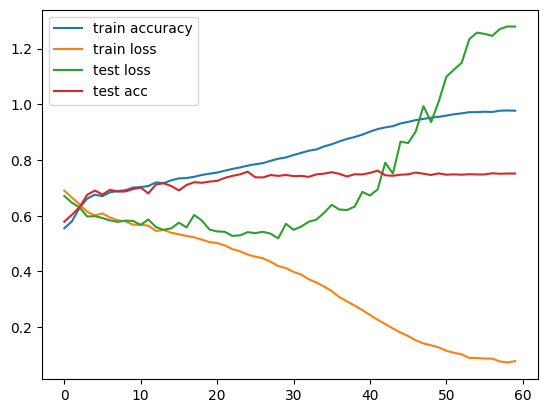

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
plt.plot(train_accuracies, label='train accuracy')
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.plot(test_accuracies, label='test acc')
plt.legend()
plt.show()
plt.savefig('weird_learning_curve.jpg')

In [15]:
torch.save(model.state_dict(), "my_model.pth")